In [6]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random

O dataset é constituído por imagens de dimensões 32 x 32 x 3 com os 3 canais RGB

In [5]:
def load(arr, path):
    for filename in os.listdir(path):
        arr.append(np.reshape(cv2.imread(os.path.join(path, filename)), (3072,)))

In [ ]:
if not os.path.exists("test.txt"):
    test_x = []
    load(test_x, "test/FAKE/")
    load(test_x, "test/REAL/")
    train_x = []
    load(train_x, "train/FAKE/")
    load(train_x, "train/REAL/")
    # Os dados são salvos como arquivo binário para acelerar a leitura dos dados
    # na próxima leitura
    np.array(test_x).tofile("test.txt", dtype=np.uint8)
    np.array(train_x).tofile("train.txt", dtype=np.uint8)

Os dados são números inteiros de 0 a 255 representando o valor de cada pixel, para normalizar os dados precisamos apenas dividir todos os valores por 255

In [8]:
test_x = np.fromfile("test.txt", dtype=np.uint8).reshape((20000, 32, 32, 3)) / 255
train_x = np.fromfile("train.txt", dtype=np.uint8).reshape((100000,32, 32,3)) / 255
print(test_x.shape, train_x.shape)

(20000, 32, 32, 3) (100000, 32, 32, 3)


Os dados estão distribuídos de forma que a primeira metade dos dados faz parte da classe falsa e a segunda metade da classe real. Os vetores y são preenchidos com 0s e 1s de acordo com as classes

In [9]:
test_y = np.append(np.zeros((10000,)), np.ones((10000,)))
train_y = np.append(np.zeros((50000,)), np.ones((50000,)))
print(test_y.shape, train_y.shape)

(20000,) (100000,)


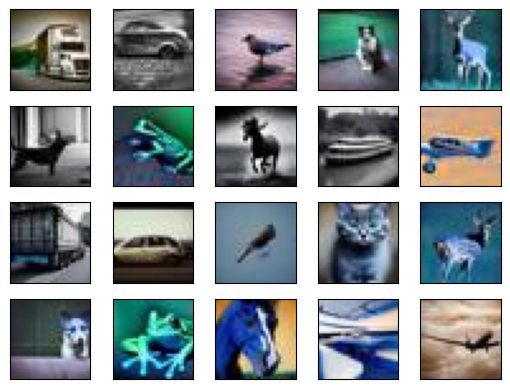

In [197]:
for i in range(1,21):
    plt.subplot(4, 5, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_x[i-1])

In [28]:
def shuffled_data(data_x, data_y):
    new_data = list(zip(data_x, data_y))
    random.shuffle(new_data)
    new_data = np.array(new_data, dtype=object).transpose()
    return (np.array([x for x in new_data[0]]), new_data[1])
    

In [29]:
def auxiliar_data(data_x, data_y, size):
    half = int(len(data_x) / 2)
    fake_x, fake_y = shuffled_data(data_x[:half], data_y[:half])
    real_x, real_y = shuffled_data(data_x[half:], data_y[half:])
    x = np.append(fake_x[:int(size/2)], real_x[:int(size/2)], 0).astype(np.uint8)
    y = np.append(fake_y[:int(size/2)], real_y[:int(size/2)], 0).astype(np.uint8)
    return (x,y)


In [30]:
flat_train_x = train_x.reshape(len(train_x), 3072)
flat_test_x = test_x.reshape(len(test_x), 3072)

In [31]:
aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)


In [13]:
aux_train_x.shape

(2000, 3072)

In [14]:
from sklearn.neighbors import KNeighborsClassifier

A primeira solução para resolver o problema vai ser o modelo de K-vizinhos mais próximos. O primeiro passo é decidir os hiper parâmetros do modelo, para isso vamos testar os valores do parâmetro k de 1 a 20 e comparar os resultados obtidos com cada valor de k

In [15]:
if os.path.exists("knn_scores.npy"):
    with open('knn_scores.npy', 'rb') as f:
        knn_scores = np.load(f, allow_pickle=True)
else:
    knn_scores = []
    for i in range(1, 20):
        mean = []
        for k in range(10):
            aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
            aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)
            knn_model = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
            knn_model.fit(aux_train_x, aux_train_y)
            mean.append(knn_model.score(aux_test_x, aux_test_y))
        knn_scores.append(mean)



In [1]:
knn_scores

NameError: name 'knn_scores' is not defined

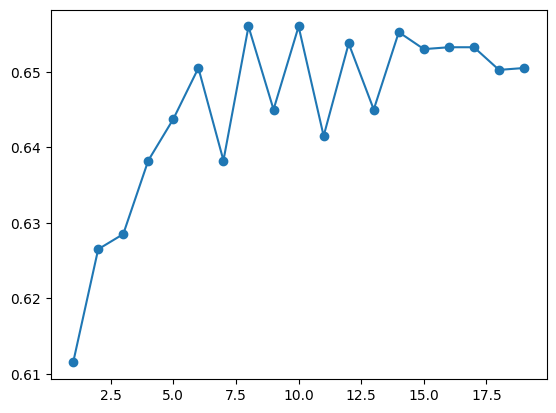

In [ ]:
plt.plot(range(1, 20), [np.mean(x) for x in knn_scores], '-o')
points_x = [np.full((len(knn_scores[0]),), i) for i in range(1,20)]
for x, y in zip(points_x, knn_scores):
    plt.scatter(x, y, color='gray', alpha=0.5)
plt.grid(axis='y')

In [ ]:
if not os.path.exists('knn_scores.npy'):
    with open('knn_scores.npy', 'wb') as f:
        np.save(f, np.array(knn_scores,dtype=object), allow_pickle=True)

In [ ]:
n = range(1, 10)[np.argmax(knn_scores)]
n

8

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
knn_model.fit(train_x.reshape((len(train_x), 3072)), train_y)
final_knn_score = knn_model.score(test_x.reshape((len(test_x), 3072)), test_y)

In [ ]:
if not os.path.exists('final_knn_score.npy'):
    with open('final_knn_score.npy', 'wb') as f:
        np.save(f, np.array(final_knn_score,dtype=object), allow_pickle=True)

In [17]:
from sklearn.tree import DecisionTreeClassifier
import itertools as it

In [79]:
tree_scores = []
criterions = ["gini", "entropy", "log_loss"]
max_depths = range(2, 10, 2)

for comb in it.product(criterions, max_depths):
    mean = []
    for k in range(5):
        aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
        aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)
        tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
        tree_model.fit(aux_train_x, aux_train_y)
        mean.append(tree_model.score(aux_test_x, aux_test_y))
    tree_scores.append(mean)

In [ ]:
if not os.path.exists('tree_scores.npy'):
    with open('tree_scores.npy', 'wb') as f:
        np.save(f, np.array(tree_scores,dtype=object), allow_pickle=True)

In [168]:
tree_scores_avg = [np.mean(x) for x in tree_scores]

In [80]:
combs = list(zip(it.product(criterions, max_depths), tree_scores_avg))
combs

[(('gini', 2), 0.6005),
 (('gini', 4), 0.6134999999999999),
 (('gini', 6), 0.6525000000000001),
 (('gini', 8), 0.6615),
 (('entropy', 2), 0.6024999999999999),
 (('entropy', 4), 0.618),
 (('entropy', 6), 0.6339999999999999),
 (('entropy', 8), 0.6235),
 (('log_loss', 2), 0.604),
 (('log_loss', 4), 0.5905),
 (('log_loss', 6), 0.6235),
 (('log_loss', 8), 0.608)]

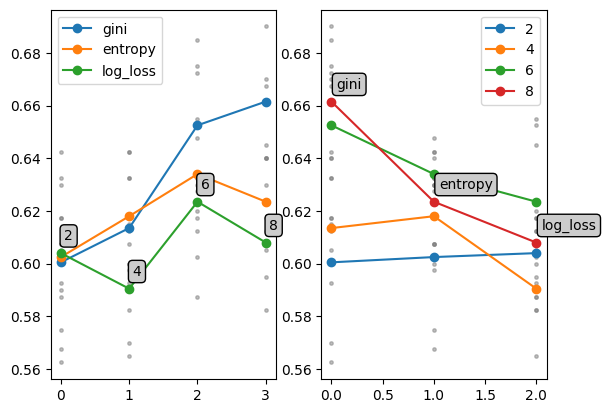

In [190]:
relation_matrix = np.array(combs, dtype=object).transpose()[0].reshape((len(criterions),len(max_depths)))

plt.subplot(1, 2, 1)
indexes = None
for param in relation_matrix:
    indexes = [np.where([y[0] == x for y in combs])[0][0] for x in param]
    plt.plot(range(len(max_depths)), [x[1] for x in [combs[i] for i in indexes]], '-o', label=param[0][0])
    plt.legend()

    points_x = [np.full((len(tree_scores[0]),), i) for i in range(len(param))]
    points_y = [tree_scores[i] for i in indexes]

    plt.scatter(points_x, points_y, color='gray', alpha=0.5, s=6)
for x, y in zip(range(len(indexes)),[tree_scores_avg[i] for i in indexes]):
    plt.annotate(str(max_depths[x]), (x+0.05, y+0.005), bbox={'boxstyle':"round", 'fc':"0.8"})

plt.subplot(1, 2, 2)
for param in relation_matrix.transpose():
    indexes = [np.where([y[0] == x for y in combs])[0][0] for x in param]
    plt.plot(range(len(param)), [x[1] for x in [combs[i] for i in indexes]], '-o', label=param[0][1])
    plt.legend()
    
    points_x = [np.full((len(tree_scores[0]),), i) for i in range(len(param))]
    points_y = [tree_scores[i] for i in indexes]
    
    plt.scatter(points_x, points_y, color='gray', alpha=0.5, s=6)

for x, y in zip(range(len(indexes)),[tree_scores_avg[i] for i in indexes]):
    plt.annotate(str(criterions[x]), (x+0.05, y+0.005), bbox={'boxstyle':"round", 'fc':"0.8"})

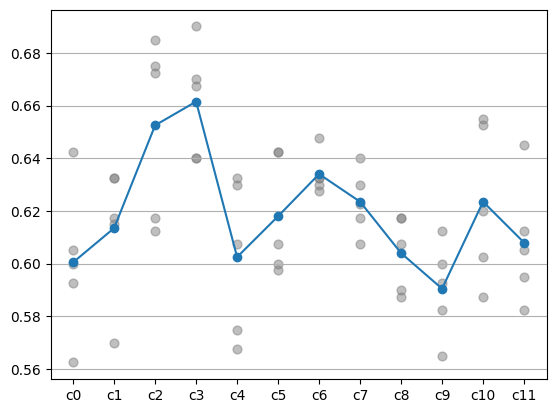

In [166]:
plt.plot([f'c{i}' for i in range(len(tree_scores))], [np.mean(x) for x in tree_scores], '-o')
points_x = [np.full((len(tree_scores[0]),),i)for i in range(len(tree_scores))]
for x, y in zip(points_x, tree_scores):
    plt.scatter(x, y, color='gray', alpha=0.5, s=40)
plt.grid(axis='y')
None

In [27]:

aux_test_x, aux_test_y = auxiliar_data(flat_test_x, test_y, 400)
aux_train_x, aux_train_y = auxiliar_data(flat_train_x, train_y, 2000)

NameError: name 'auxiliar_data' is not defined

In [ ]:
comb = list(it.product(criterions, max_depths))[np.argmax(tree_scores)]

In [ ]:
tree_model = DecisionTreeClassifier(criterion=comb[0], max_depth=comb[1])
tree_model.fit(train_x, train_y)
tree_model.score(test_x, test_y)

KeyboardInterrupt: 

In [199]:
import skops.io as sio
if not os.path.exists('tree_model.skops'):
    obj = sio.dumps(tree_model)
    sio.dump(obj, "tree_model.skops")


In [201]:
tree_model = sio.loads(sio.load("test.skops"))

['dwq', 1, (1, 'qde')]

In [2]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential
from keras.optimizers import Adamax
from keras.losses import SparseCategoricalCrossentropy

In [39]:
ann_model = Sequential()

ann_model.add(Dense(256, activation="relu"))
ann_model.add(Dense(128, activation="relu"))
ann_model.add(Dense(64, activation="relu"))
ann_model.add(Dense(2, activation="sigmoid"))

In [40]:
ann_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [42]:
ann_model.fit(aux_train_x, aux_train_y,epochs=5, validation_split=0.2)

Epoch 1/5
50/50 [==============================] - 1s 29ms/step - loss: 8.3413 - accuracy: 0.6106 - val_loss: 32.2553 - val_accuracy: 0.0375
Epoch 2/5
50/50 [==============================] - 1s 27ms/step - loss: 3.1798 - accuracy: 0.6825 - val_loss: 0.8449 - val_accuracy: 0.9000
Epoch 3/5
50/50 [==============================] - 1s 20ms/step - loss: 3.5903 - accuracy: 0.6700 - val_loss: 8.9504 - val_accuracy: 0.2325
Epoch 4/5
50/50 [==============================] - 1s 22ms/step - loss: 3.1611 - accuracy: 0.6550 - val_loss: 0.7271 - val_accuracy: 0.9100
Epoch 5/5
50/50 [==============================] - 1s 20ms/step - loss: 3.3783 - accuracy: 0.6837 - val_loss: 6.9354 - val_accuracy: 0.2500


In [43]:
ann_model.evaluate(flat_test_x, test_y)

625/625 [==============================] - 5s 7ms/step - loss: 3.4673 - accuracy: 0.5868


[3.4672722816467285, 0.5867999792098999]

In [50]:
ann_model.layers[0].get_weights()[1].shape

(256,)

In [ ]:
if not os.path.exists('ann_model.txt'):
    ann_model.save("ann_model.txt")

In [189]:
cnn_model = Sequential()

cnn_model.add(Conv2D(128, 3, input_shape=(32,32,3), activation="relu"))
cnn_model.add(MaxPool2D())
cnn_model.add(Conv2D(128, 3))
cnn_model.add(MaxPool2D())

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation="relu"))
cnn_model.add(Dense(128, activation="relu"))
cnn_model.add(Dense(64, activation="relu"))
cnn_model.add(Dense(2, activation="sigmoid"))

In [190]:
cnn_model.compile(optimizer=Adamax(), loss=SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [178]:
cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 29, 29, 128)       6272      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 128)       262272    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 5, 5, 128)        0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 3200)              0         
                                                                 
 dense_56 (Dense)            (None, 256)             

In [191]:
cnn_model.fit(aux_train_x.reshape((len(aux_train_x),32,32,3)), aux_train_y, epochs=5)

Epoch 1/5
63/63 [==============================] - 17s 225ms/step - loss: 4.0507 - accuracy: 0.6150
Epoch 2/5
63/63 [==============================] - 15s 234ms/step - loss: 0.5211 - accuracy: 0.7465
Epoch 3/5
63/63 [==============================] - 15s 236ms/step - loss: 0.4778 - accuracy: 0.7710
Epoch 4/5
63/63 [==============================] - 15s 230ms/step - loss: 0.3788 - accuracy: 0.8195
Epoch 5/5
63/63 [==============================] - 15s 237ms/step - loss: 0.2979 - accuracy: 0.8695


In [192]:
cnn_model.evaluate(test_x, test_y)

625/625 [==============================] - 41s 65ms/step - loss: 0.5414 - accuracy: 0.7492


[0.5414159297943115, 0.7491999864578247]

In [57]:
filters, bias = cnn_model.layers[0].get_weights()

In [58]:
filters.shape

(3, 3, 3, 128)

In [106]:
np.shape(np.flip(filters[:,:,0,0:4]))

(3, 3, 4)

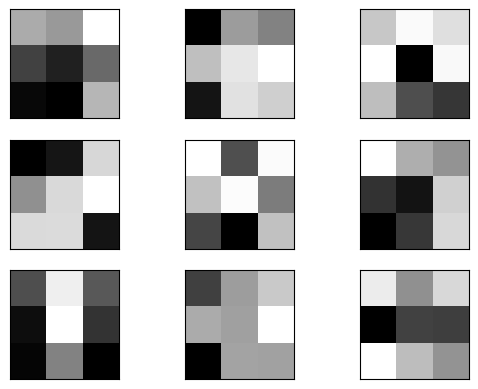

In [145]:
for i in range(1,10):
    plt.subplot(3,3,i)
    f = filters[:,:,0,i-1]
    mn, mx = (f.min(), f.max())
    if mn < 0:
        mn *= -1 
    else:
        mn = 0
    f = (f + mn) / (mn+mx)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(f, cmap="gray")

In [ ]:
if not os.path.exists('cnn_model.txt'):
    cnn_model.save("cnn_model.txt")

In [68]:
cnn_model.layers[:1]

In [126]:
mm = Sequential(layers=cnn_model.layers[:1])

In [127]:
mm.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
Total params: 3,584
Trainable params: 3,584
Non-trainable params: 0
_________________________________________________________________


In [146]:
im = mm.predict(test_x[:1])
np.shape(im[0][:,:,:])

1/1 [==============================] - 1s 605ms/step


(30, 30, 128)

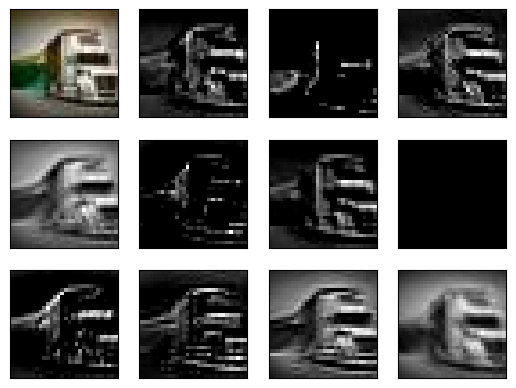

In [144]:
plt.subplot(3,4,1)
plt.xticks([])
plt.yticks([])
plt.imshow(test_x[0])

for i in range(2,13):
    plt.subplot(3,4,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(im[0][:,:,i-2], cmap='gray')